# Analysis of MD2NMR

Here we investigate effect of max-match and num-matches and evaluate the accuracy with respect to observed values.

In [20]:
import sys, os, re, glob, multiprocessing, argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
sys.path.append("/home/dkoes/git/MD2NMR/")
import shiftres,shifts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Load observed values

In [2]:
observed = dict()
for fname in glob.glob('*.obs.csv'):
    (prot,_,_) = fname.split('.')
    observed[prot] = dict()
    for line in open(fname):
        (rname,rid,N,H,C) = line.split(',')
        observed[prot][int(rid)] = tuple(map(float,(N,H,C)))

In [3]:
prots = [f.split('/')[-1] for f in glob.glob('benchmark/*')]

In [4]:
ffs = [f.split('/')[-1] for f in glob.glob('benchmark/1enh/*')]

In [5]:
def calc_error(obs,calc):
    '''Compute RMSD between two dictionaries mapping resid -> CHN'''
    Ndiff = np.array([ obs[v][0]-calc[v][0] for v in sorted(obs.keys())])
    Hdiff = np.array([ obs[v][1]-calc[v][1] for v in sorted(obs.keys())])
    Cdiff = np.array([ obs[v][2]-calc[v][2] for v in sorted(obs.keys())])
    Nerr = np.sqrt(np.mean(np.square(Ndiff)))
    Herr = np.sqrt(np.mean(np.square(Hdiff)))
    Cerr = np.sqrt(np.mean(np.square(Cdiff)))
    return (Nerr,Herr,Cerr)

In [6]:
def load_shifts(fname):
    ret = dict()
    for line in open(fname):
        if not line.startswith('#'):
            (rid, rname, N,H,C,_,_,_,_) = line.split()
            ret[int(rid)] = tuple(map(float,(N,H,C)))
    return ret

Have precalculated shifts for all trajectories.  Load these in, average, and compute error for every protein/forcefield.

In [7]:
errors = dict()
errors['default'] = dict() #selct top
errors['0.2_1'] = dict() #select top within 0.2
errors['0.2_5'] = dict() #select top 5 within 0.2
errors['5'] = dict() #select top 5
for ff in ffs:
    for k in errors.keys():
        errors[k][ff] = dict()
    for prot in prots:
        if prot in observed: #skip 1l2y since it only has H
            for k in errors.keys():
                errors[k][ff][prot] = []
            for fname in glob.glob('benchmark/%s/%s/*.shifts'%(prot,ff)):
                shifts = load_shifts(fname)
                if fname.endswith('_0.2_1.shifts'):
                    err = errors['0.2_1']
                elif fname.endswith('_0.2_5.shifts'):
                    err = errors['0.2_5']
                elif fname.endswith('__5.shifts'):
                    err = errors['5']
                else:
                    err = errors['default']
                err[ff][prot].append(calc_error(observed[prot],shifts))

In [8]:
aveerrors = dict()
for k in errors.keys():
    aveerrors[k] = dict()
    for ff in errors[k]:
        aveerrors[k][ff] = dict()
        for prot in errors[k][ff]:
            aveerrors[k][ff][prot] = np.mean(errors[k][ff][prot],axis=0)

In [9]:
#ave across proteins
protave = dict()
for k in aveerrors.keys():
    protave[k] = dict()
    for ff in aveerrors[k]:
        protave[k][ff] = np.mean(aveerrors[k][ff].values(),axis=0)

In [10]:
#ave across forcefields
totave = dict()
for k in protave.keys():
    totave[k] = np.mean(protave[k].values(),axis=0)

In [11]:
totave

{'0.2_1': array([ 6.38392731,  1.67898114,  2.05287635]),
 '0.2_5': array([ 6.36494081,  1.68040514,  2.02206865]),
 '5': array([ 6.10765312,  1.65420947,  1.98066241]),
 'default': array([ 6.1919454 ,  1.65603785,  2.04131587])}

**Conclusion**: Taking the five best matches does slightly better than only the top match, but imposing a cutoff does not help.

In [12]:
Nerr = []
Herr = []
Cerr = []
labels = []
for ff in aveerrors['5'].keys():
    labels.append(ff)
    Nerr.append(np.vstack(aveerrors['5'][ff].values())[:,0])
    Herr.append(np.vstack(aveerrors['5'][ff].values())[:,1])
    Cerr.append(np.vstack(aveerrors['5'][ff].values())[:,2])

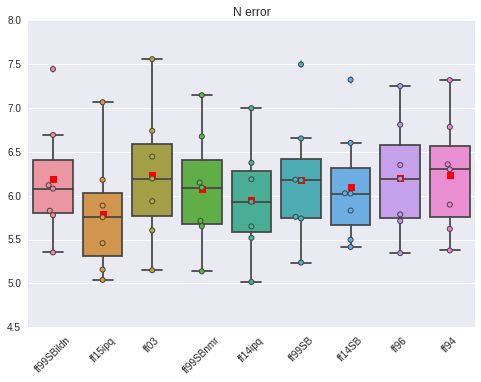

In [13]:
sns.boxplot(data=Nerr,showmeans=True)
sns.swarmplot(data=Nerr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('N error');

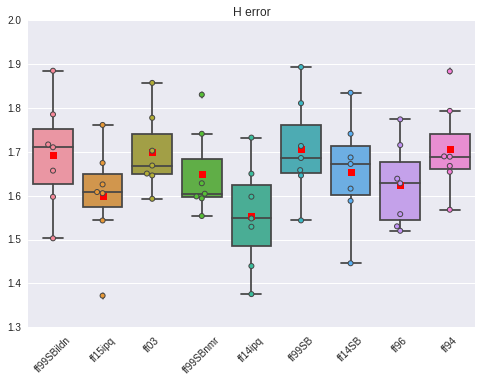

In [14]:
sns.boxplot(data=Herr,showmeans=True)
sns.swarmplot(data=Herr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('H error');

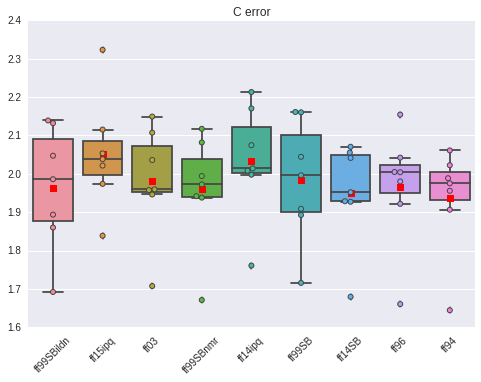

In [15]:
sns.boxplot(data=Cerr,showmeans=True)
sns.swarmplot(data=Cerr,linewidth=1)
plt.xticks(xrange(len(labels)),labels,rotation=45);
plt.title('C error');

In [16]:
data = pd.DataFrame(columns=['ff','prot','N','H','C'])
for ff in errors['5'].iterkeys():
    for prot in errors['5'][ff].iterkeys():
        for (N,H,C) in errors['5'][ff][prot]:
            data.loc[len(data)] = [ff,prot,N,H,C]

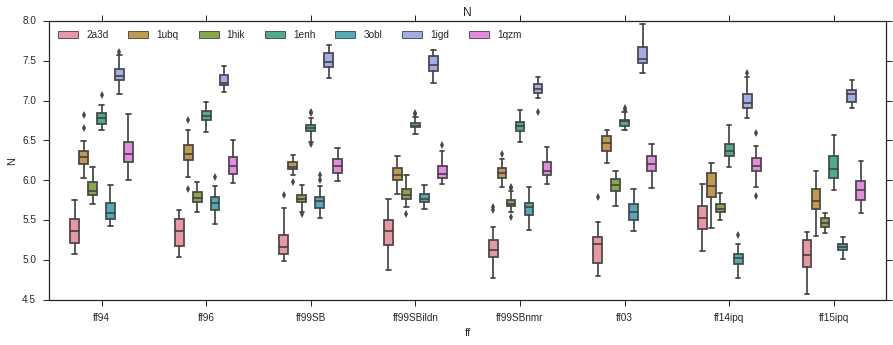

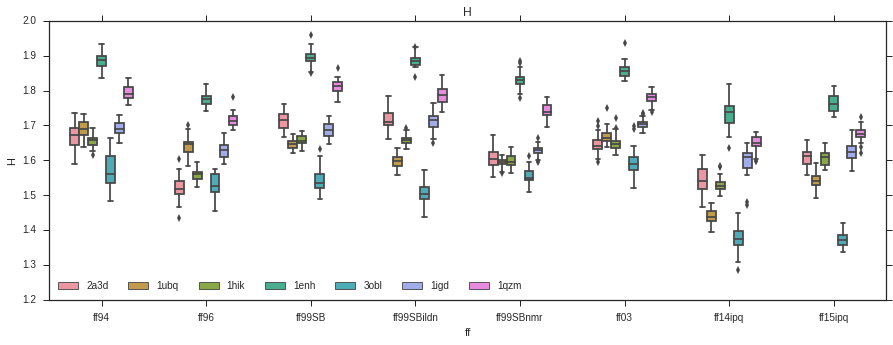

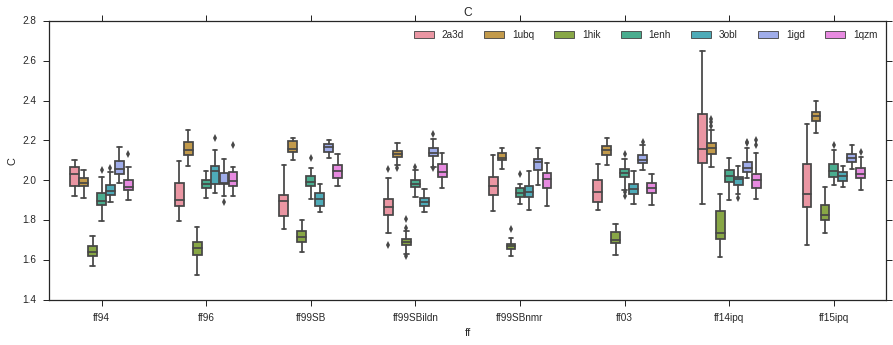

In [21]:
for S in ['N','H','C']:
    plt.figure(figsize=(15,5))
    sns.set(style="ticks")
    sns.boxplot(x='ff',y=S,hue='prot',data=data,width=.6,order=['ff94','ff96','ff99SB','ff99SBildn','ff99SBnmr','ff03','ff14ipq','ff15ipq'])
    plt.legend(loc='best',ncol=7)
    plt.title(S)
    plt.show()

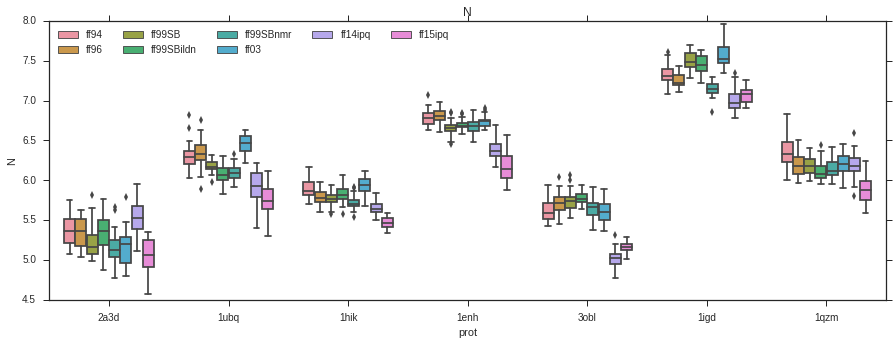

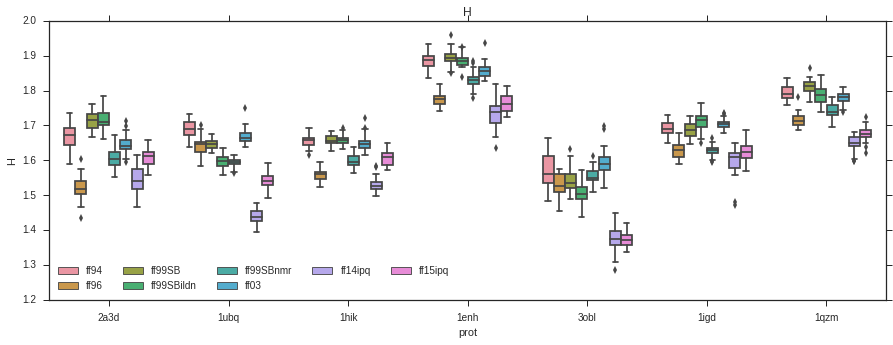

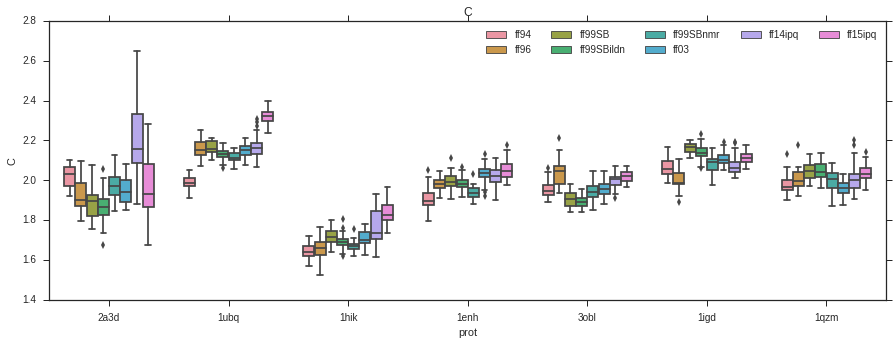

In [23]:
for S in ['N','H','C']:
    plt.figure(figsize=(15,5))
    sns.set(style="ticks")
    sns.boxplot(x='prot',y=S,hue='ff',data=data,width=.75,hue_order=['ff94','ff96','ff99SB','ff99SBildn','ff99SBnmr','ff03','ff14ipq','ff15ipq'])
    plt.legend(loc='best',ncol=5)
    plt.title(S)
    plt.show()